In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

2017-08-23
2016-08-23
2230


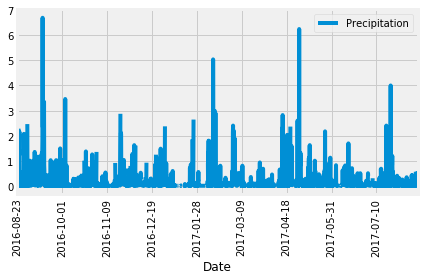

<Figure size 432x288 with 0 Axes>

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# results = session.query()order_by(Emoji.score.desc()).all()

#looking at the columns and data sample
first_row = session.query(Measurement).first()
first_row.__dict__

#finding the max date
results=session.query(Measurement.date, Measurement.prcp).order_by(Measurement.date.desc()).first()
results
#('2017-08-23', 0.0)

last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]

print(last_date) 

last_date_measurement = dt.date(2017, 8 ,23)
# Calculate the date 1 year ago from the last data point in the database
one_year_ago = last_date_measurement - dt.timedelta(days=365)
print(one_year_ago)

date = dt.date(2016, 8, 23)

# Perform a query to retrieve the data and precipitation scores
qry = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date <= '2017-08-23').\
    filter (Measurement.date >= '2016-08-23').all()
# Save the query results as a Pandas DataFrame and set the index to the date column
result = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= date).all()

# get the count / length of the list of tuples
print(len(result))

df = pd.DataFrame(result, columns=['Date', 'Precipitation'])
df = df.sort_values('Date')
df.set_index('Date', inplace=True)
df.plot.line(rot=90)
plt.tight_layout()
plt.show()
plt.savefig("./date_vs_precipitation.png")

![precipitation](Images/precipitation.png)

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [12]:
# Design a query to show how many stations are available in this dataset?

# first_row.__dict__
stations=session.query(Measurement.station)
measure_stations=[]
for s in stations:
#     print(s)
    measure_stations.append(s[0])

stations_df=pd.DataFrame({'stations':measure_stations})
station_counts=stations_df['stations'].value_counts()
unique_stations_count=len(station_counts)

#Number of stations in the dataset
unique_stations_count #9


9

In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_counts

USC00519281    2772
USC00519397    2724
USC00513117    2709
USC00519523    2669
USC00516128    2612
USC00514830    2202
USC00511918    1979
USC00517948    1372
USC00518838     511
Name: stations, dtype: int64

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
highest_temp=session.query(Measurement.tobs).filter(Measurement.station == 'USC00519281').order_by(Measurement.tobs.desc()).first()
lowest_temp=session.query(Measurement.tobs).filter(Measurement.station == 'USC00519281').order_by(Measurement.tobs.asc()).first()

# first_row.__dict__

#collecting teh temerature data for station == 'USC00519281'
a_temp=session.query(Measurement.tobs).filter(Measurement.station == 'USC00519281')

#Calculating the total temperature
total_tmp=0
for temp in a_temp:
#     print(temp[0])
    total_tmp+=temp[0]

print(total_tmp)

#Counting the number of rows
tmp_count=session.query(Measurement.tobs).filter(Measurement.station == 'USC00519281').count()
tmp_count

#Average temeratuer calculation
avg_tmp=total_tmp/tmp_count

lowest_temp,highest_temp,avg_tmp

198652.0


((54.0), (85.0), 71.66378066378067)

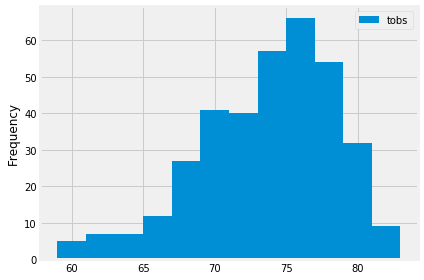

<Figure size 432x288 with 0 Axes>

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# Calculate the date 1 year ago from the last data point in the database

#finding the max date for station == 'USC00519281'
results=session.query(Measurement.date).filter(Measurement.station == 'USC00519281').order_by(Measurement.date.desc()).first()
results
#('2017-08-18')

# Perform a query to retrieve the data and precipitation scores
results_tobs_hist = session.query(Measurement.tobs).filter(Measurement.station == 'USC00519281').\
filter(Measurement.date <= '2017-08-18').\
    filter (Measurement.date >= '2016-08-18').all()

# PLOT THE HISTOGRAM

df = pd.DataFrame(results_tobs_hist, columns=['tobs'])
df.plot.hist(bins=12)
plt.tight_layout()
plt.show()
plt.savefig("./histogram_12mnth_temp.png")
# need to adjust x and y axis, tickers, and bar thickness, and axis title

![precipitation](Images/station-histogram.png)

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2017-02-28', '2017-03-05'))

[(64.0, 72.02777777777777, 78.0)]


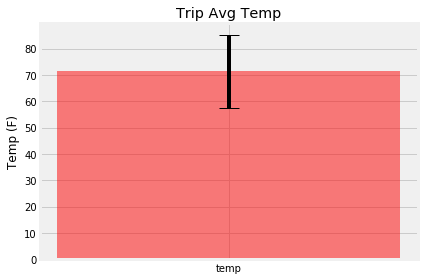

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
tmin=64.0
tavg=72.03
tmax=78.0
yerr=(tmax-tmin)
x=np.array([64.0,72.03,78.0])
x_mean=np.mean(x)
x_std=np.std(x)
# Create lists for the plot
temp = ['temp']
x_pos = np.arange(len(temp))
CTEs = [x_mean]
error = [yerr]
y=(72.03)

# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, CTEs, yerr=error,width=0.05, align='center', alpha=0.5, ecolor='black', color='red',capsize=10)
ax.set_ylabel('Temp (F)')
ax.set_xticks(x_pos)
ax.set_xticklabels(temp)
ax.set_title('Trip Avg Temp')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.savefig('bar_plot_with_error_bars.png')
plt.show()


In [50]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
# inspector = inspect(engine)
# columns = inspector.get_columns('station')
# for c in columns:
#     print(c['name'], c['type'])

# print('_'*12)
# columns = inspector.get_columns('measurement')
# for c in columns:
#     print(c['name'], c['type'])
    
# join_result = engine.execute('SELECT * FROM measurement INNER JOIN station ON measurement.station = station.station;').fetchall()

# engine.execute('SELECT DISTINCT station,date, sum(prcp) FROM measurement GROUP BY station,date ORDER BY sum(prcp) DESC').\
# fetchall()

# result=session.query(Measurement,Station).filter(Measurement.station == Station.station).filter(Measurement.date == '2014-07-20').all()
# # for row in result:
# #         print(row)
# join_result[0]

# for m, s in session.query(Measurement,Station).filter(Measurement.station == Station.station).filter(Measurement.date >= '2014-07-20').filter(Measurement.date <= '2014-08-15').all():
#     print ("station: {} Name: {} precipitation: {} Elevation: {} Longitude:{} Latitude:{}  date:{} temperature:{}".format(m.station,s.name,m.prcp, s.elevation,s.longitude,s.latitude,m.date,m.tobs))

# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
join_result2 = engine.execute('SELECT Measurement.station,date,Station.name,Station.Longitude,Station.Latitude, sum(prcp) FROM Measurement INNER JOIN Station ON Measurement.station = Station.station and Measurement.date<="2014-08-15" and Measurement.date >= "2014-07-20" GROUP BY Measurement.station,date,Station.name,Station.Longitude,Station.Latitude ORDER BY sum(prcp) DESC;').fetchall()
join_result2

[('USC00514830', '2014-07-20', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', -157.8374, 21.5213, 11.53),
 ('USC00519281', '2014-07-20', 'WAIHEE 837.5, HI US', -157.84888999999998, 21.45167, 7.97),
 ('USC00513117', '2014-07-20', 'KANEOHE 838.1, HI US', -157.8015, 21.4234, 5.98),
 ('USC00519523', '2014-07-20', 'WAIMANALO EXPERIMENTAL FARM, HI US', -157.71139, 21.33556, 5.54),
 ('USC00516128', '2014-07-20', 'MANOA LYON ARBO 785.2, HI US', -157.8025, 21.3331, 4.3),
 ('USC00516128', '2014-07-27', 'MANOA LYON ARBO 785.2, HI US', -157.8025, 21.3331, 1.43),
 ('USC00516128', '2014-08-09', 'MANOA LYON ARBO 785.2, HI US', -157.8025, 21.3331, 1.2),
 ('USC00516128', '2014-08-08', 'MANOA LYON ARBO 785.2, HI US', -157.8025, 21.3331, 1.1),
 ('USC00519397', '2014-07-20', 'WAIKIKI 717.2, HI US', -157.8168, 21.2716, 1.09),
 ('USC00511918', '2014-07-20', 'HONOLULU OBSERVATORY 702.2, HI US', -157.9992, 21.3152, 1.0),
 ('USC00516128', '2014-08-02', 'MANOA LYON ARBO 785.2, HI US', -157.8025, 21.3331, 0.95),
 ('U

## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")


In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
